# Guided Project: Predicting Insurance Costs with Linear Regression Modelling

## Table of Contents 
1. [Introduction](#introduction)
2. [Exploring the Dataset](#exploring-data)
3. [Dividing The Data](#dividing)
4. [Build The Model](#build)
5. [Residual Diagnostics](#residual)
6. [Final Model Evaluation](#final)
7. [Drawing Conclusions](#drawing)


## Introduction <a name='introduction'></a>

This is a project I completed based on a guide called 'Predicting Insurance Costs' on the Dataquest learning platform. 

In this project I have learned new skills related to Linear Regression Modelling 

The implementation is written in Python, and is shown in Jupyter Notebooks.

### Goal of this project

Our task is to understand how the characteristics obseved in the  [Medical Cost Data Set](#https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle relate to the total medical cost using regression analysis. Since the cost is a continuous, positive value, linear regression seems appropriate. Our objective is to create an accurate predictive model for medical costs, which can help hospitals predict revenue and plan patient-related procedures effectively. This project holds importance in healthcare management, aiding in informed decision-making and resource allocation.

![closeup-cash-stethoscope-healthcare-expenses-concept_small1.jpg](img/predictinsurancecost/cash-stethoscope_small1.jpg)

Source: [Image by rawpixel.com on Freepik](https://www.freepik.com/free-photo/closeup-cash-stethoscope-healthcare-expenses-concept_19133804.htm#fromView=search&page=1&position=37&uuid=4ef7ad94-178b-4952-9403-0512dcb1fa4a)

## Exploring the Dataset <a name='exploring-data'></a>

### Import the dependencies
First we need to import the required libraries: pandas, numpy, scikit-learn, seaborn and matplotlib.pyplot.


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### Load and explore the data
The values of the insurance costs are stored in 1 file:
1. insurance.csv

In [55]:
# load files into dataframes
insurance_df = pd.read_csv('data/predictinsurancecost/insurance.csv')
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There are 1'338 entries in the dataset, with 7 columns consisting of text and numbers. 

#### Explore examples of the outcomes ('charges') and the correlations

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


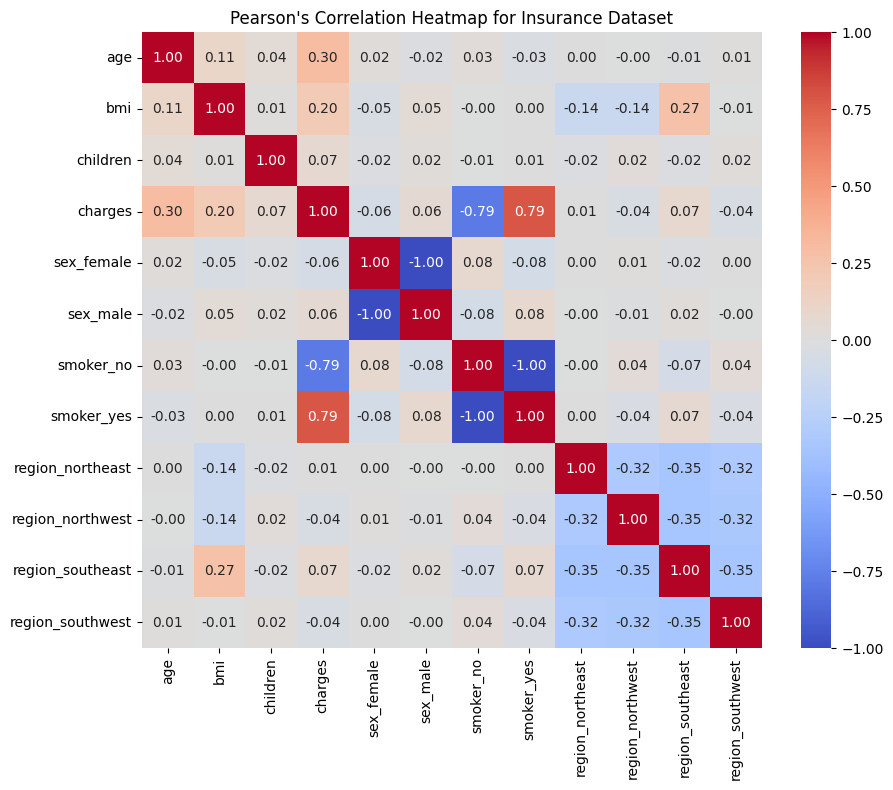

In [56]:
# look at examples of the outcomes ('charges')
print(insurance_df['charges'])
print(insurance_df['charges'].describe())

# create dummies for categorical columns
insurance_df_dummies = pd.get_dummies(insurance_df)

# Calculate Pearson's correlation coefficient
correlation_matrix = insurance_df_dummies.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Pearson's Correlation Heatmap for Insurance Dataset")
plt.show()

### Observations
Some initial observations about the insurance data set
1. Charges (costs)
- the average cost is 13'270
- the minimum cost is 1'121
- the maximum cost is 63'770
- the value of one standard deviation to the costs is 12'110
2. Correlations of all columns against charges column, above 0.2 or below -0.2, ranked from strongest 
- smoker: 0.79
- age: 0.3
- bmi: 0.2


From a pure data analysis perspective, it therefore makes sense to include these 3 columns in our data subset, as they can be good predictors for linear regression.
In addition, it makes sense from domain knowledge, that common drivers in early mortality rates and illness occurence are health risks such as smoking and obesity (which can be measured by BMI).

3. Correlations of all columns against each other (exluding charges), above 0.2 or below -0.2,
- bmi and region_southeast has a correlation of 0.27. It appears people living in the South East region of the USA have a higher BMI than the rest of the population.

Let's look at the relationships between the potential predictor variables with the outcome via plots. See if stratifying by a predictor shows a meaningful difference in the distribution of the outcome. 

array([[<Axes: title={'center': 'charges'}>]], dtype=object)

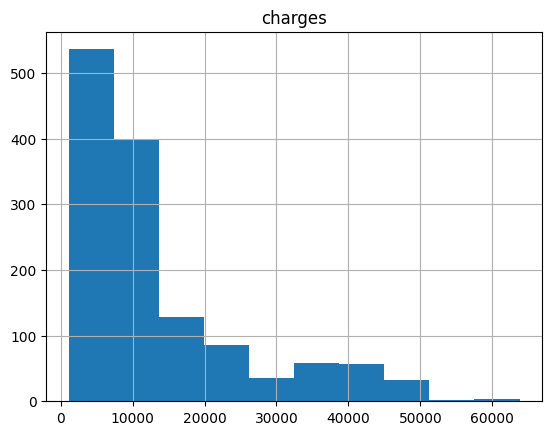

In [57]:
insurance_df.hist('charges')

The outcomes are higly skewed to the right - a large percentage of outcomes are leaning towards the lower charges. Using a logarithmic transformation, let's try to transform the outcome so that extreme values are attenuated and the outcome has a more balanced distribution.

array([[<Axes: title={'center': 'log_charges'}>]], dtype=object)

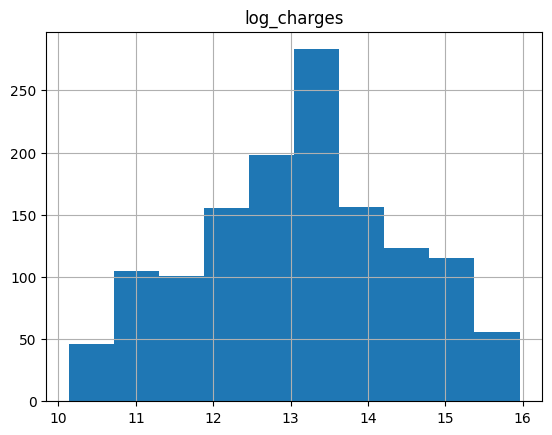

In [58]:
insurance_df['log_charges'] = np.log2(insurance_df['charges'])

insurance_df.hist('log_charges')

Above, one can see that the log transformation results in a more centred distribution of the outcomes.

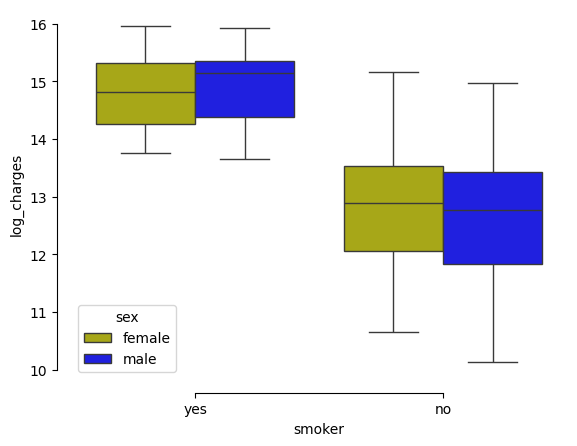

In [59]:
# Distribution of log_charges by categorical columns, part 1

# Draw 
sns.boxplot(data = insurance_df, x='smoker', y='log_charges',
            hue='sex', palette=['y', 'b']
            )
sns.despine(offset=10, trim=True)

Above, we see that the log value of charges have almost the same distributions of charges between the sexes combined with whether they are smokers or not. There is a small difference in the charges for the median of female vs. male smokers. 
Let's check another distribution between sexes, this time split by region.

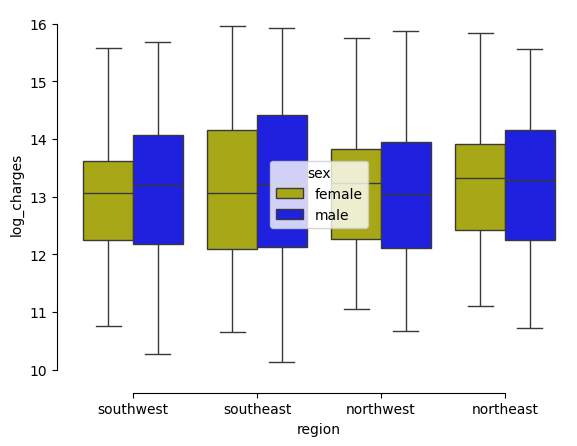

In [60]:
# Distribution of log_charges by categorical columns, part 2

# Draw 
sns.boxplot(data = insurance_df, x='region', y='log_charges',
            hue='sex', palette=['y', 'b']
            )
sns.despine(offset=10, trim=True)

Again, there is little difference in the distribution between sexes as before. Therefore, we can probably leave out the sex column as a predictor.

#### Decision: predictor variables to use
Based on the above observaions, the list of predictor variables to include in our model is therefore:
- smoker
- age 
- bmi

## Dividing The Data  <a name='dividing'></a>

We create a training set in order to estimate the regression coefficients for each of the predictors in the model. A test dataset's purpose is to get a prediction error here helps us understand how the model can be generalized.

Use a standard 70:30 ratio to divide the insurance dataset into training and test sets.

In [61]:
# Divide up the insurance data into a training set and a test set
insurance_df['is_smoker'] = insurance_df['smoker'] == 'yes'
insurance_df = insurance_df[['age', 'bmi', 'is_smoker', 'log_charges']]

X = insurance_df.drop(columns=['log_charges'])
y = insurance_df['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(936, 3)
(936,)
(402, 3)
(402,)


## Build The Model  <a name='build'></a>

we're ready to build our predictive linear model. During this step we will also evaluate the quality of our model. 

In [62]:
# Construct the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Examine the coefficients of the model (using log values)
model.coef_

array([0.04997906, 0.01426245, 2.23614587])

In [63]:
# Examine the coefficients of the model (using original values)
np.exp(model.coef_)

array([1.05124909, 1.01436464, 9.3571978 ])

Recall that we selected `age`, `bmi` and `ìs_smoker` as the predictors, in that order.  
For a linear model with multiple predictors, we would interpret β1 (the coefficient) as the average increase in Y (the outcome)for a unit increase in X1 (the input value), holding the other predictors constant. By examining the coefficients in the linear model, we see that: 
- an increase of 1 unit of `age` (i.e. one year older) while `bmi` and `ìs_smoker` remain constant, results in a 5% increase in the charges, according to the original values.
- an increase of 1 unit of `bmi` (e.g. the BMI increases from 25 to 26) while `bmi` and `ìs_smoker` remain constant, results in a 1% increase in the charges, according to the original values.
- an increase of 1 unit of `ìs_smoker` while `bmi` and `age` remain constant, results in a 936 % increase in the charges, according to the original values.

Its therefore clear that the `ìs_smoker` variable has the strongest influence on the outcome. This is also expected, based on the strong correlation we saw earlier when exploring the data.

Let's now do a prediction, compare it to the actual outcomes, and evaluate the model based on its mean squared error (MSE) and coefficient of determination (R2).

In [64]:
# Prediction using the train dataset
y_pred = model.predict(X_train)

# MSE based on log results
mean_squared_error(y_train, y_pred)

0.4556974045732054

In [65]:
# MSE based on original results
np.exp(mean_squared_error(y_train, y_pred))

1.577272996952803

In [66]:
# R2 based on log results
r2_score(y_train, y_pred)

0.7346481189353116

The MSE is very low with an original value of 1.58, indicating a good model. Also, 74% of the variation in the outcome can be explained by the model, also an indication of a good model.

##  Residual Diagnostics  <a name='residual'></a>
We check how well the assumptions of linear regression are met.

<Axes: xlabel='fitted', ylabel='residuals'>

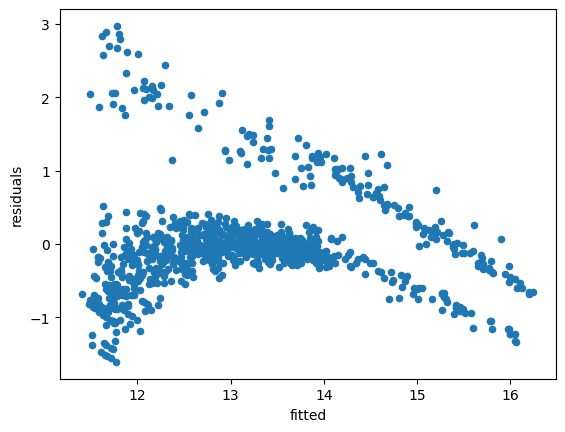

In [67]:
# Calculate the fitted and residual values
check_df = pd.DataFrame()
check_df["residuals"] = y_train - y_pred
check_df["fitted"] = y_pred

check_df.plot.scatter(x = "fitted", y = "residuals")

From the above, the residuals are not constantly increasing as the fitted values are increasing. This is something not quite expected for a linear relationship.
Also, there is no centering of residual values around 0, which is also not expected.
This could lead to the assumption that the linear regression model may not be the best choice for the problem.

## Final Model Evaluation  <a name='final'></a>

Let's see how the model performs on the test data, which represents a set of new observations that the model hasn't been trained on.

In [68]:
y_test_pred = model.predict(X_test)

# MSE on test data, log values
mean_squared_error(y_test, y_test_pred)

0.4350008671495479

In [69]:
# MSE on test data, original values
np.exp(mean_squared_error(y_test, y_test_pred))

1.5449643986659374

## Drawing Conclusions  <a name='drawing'></a>
Discuss the results of all of the observations made during the predictive modeling process.

After the final model evaluation we saw that the MSE values on the test data are quite close to the values of 0.46 and 1.58 that we saw earlier on the training data. Therefore, we can say there is little overfitting taking place.
While checking the residuals, it became clear that the model is predicting lower costs for subjects who were actually on the higher end. We may want improve the model by including additional features where possible, or to make more complex predictors, such as polynomial or interaction terms.